Never closed:  5 0.8
Closed in more than 50%:  543 91.7
Closed in more than 75%:  506 85.5
Closed in more than 99%:  75 12.7


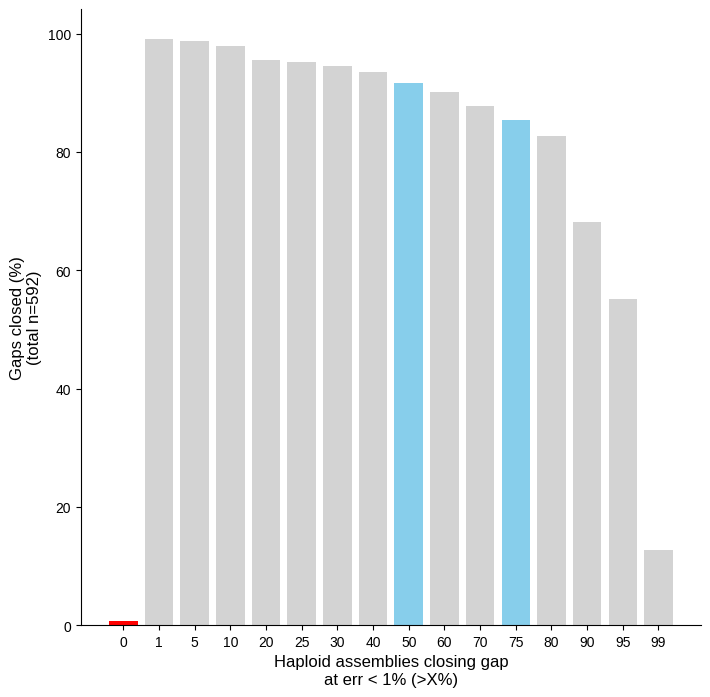

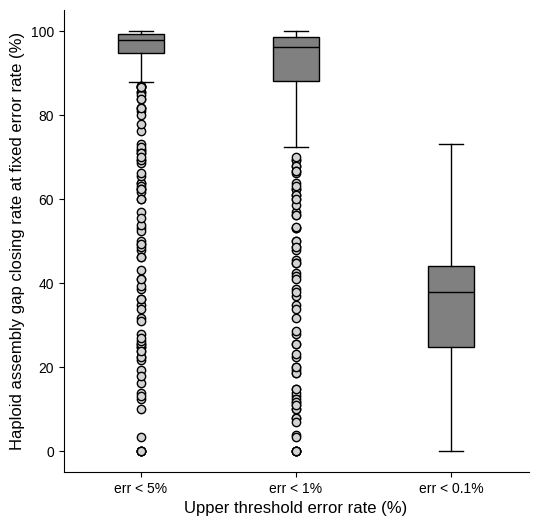

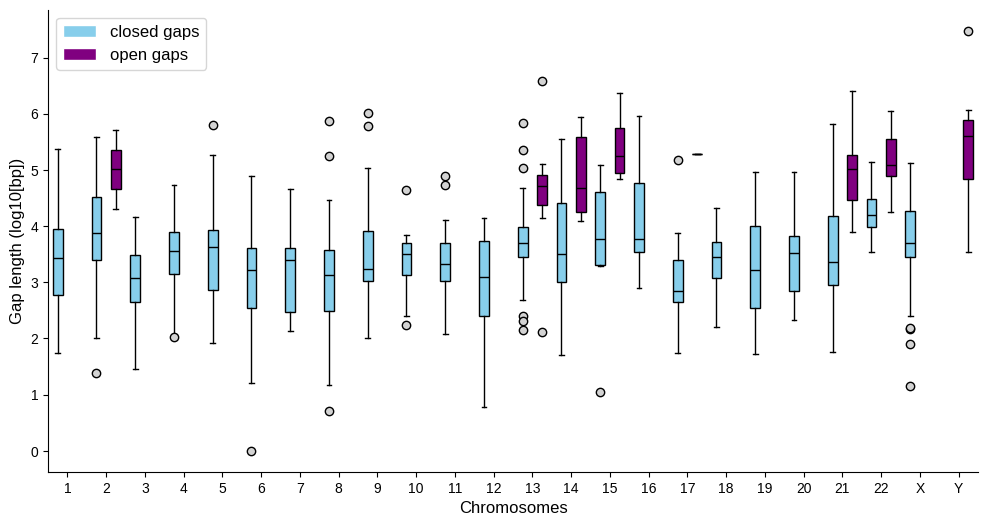

In [2]:
import pathlib
import functools
import statistics
import matplotlib.pyplot as plt
import collections as col

import pandas as pd
import numpy as np

pd.set_option('future.no_silent_downcasting', True)

%cd -q "/home/ebertp/work/code/cubi/project-run-hgsvc-hybrid-assemblies/notebooks"

_PROJECT_CONFIG_NB = str(pathlib.Path("00_project_config.ipynb").resolve(strict=True))
_PLOT_CONFIG_NB = str(pathlib.Path("05_plot_config.ipynb").resolve(strict=True))

%run $_PROJECT_CONFIG_NB
%run $_PLOT_CONFIG_NB

_MYNAME="hprc-gap-summary"
_MYSTAMP=get_nb_stamp(_MYNAME)

_MY_OUT_PATH = PLOT_OUT_SUPPL_FIG.joinpath("hprc_gaps")

SUMMARY_FILE = out_file = PROJECT_DATA_ROOT.joinpath(
    "2024_gap_eval", "sample_summary.all-t.pre-supp-table.tsv"
).resolve(strict=True)


df = pd.read_csv(SUMMARY_FILE, sep="\t", header=0)

def plot_continuous_closing_rate(table, error_rate="1pct", skip_save=False):

    plot_column = f"closed_haps_pct_{error_rate}"
    x_values = table[plot_column].values
    total_gaps = x_values.size

    thresholds = [0, 1, 5, 10, 20, 25, 30, 40, 50, 60, 70, 75, 80, 90, 95, 99]
    
    gap_count = []
    gap_percent = []
    for t in thresholds:
        if t == 0:
            n = (x_values < 0.1).sum()
            gap_count.append(n)
            p = round(n/total_gaps * 100, 1)
            gap_percent.append(p)
            print("Never closed: ", n, p)
        else:
            n = (x_values > t).sum()
            gap_count.append(n)
            p = round(n/total_gaps * 100, 1)
            gap_percent.append(p)
            if t == 50:
                print("Closed in more than 50%: ", n, p)
            if t == 75:
                print("Closed in more than 75%: ", n, p)
            if t == 99:
                print("Closed in more than 99%: ", n, p)

    fig, ax = plt.subplots(figsize=(8,8))

    colors = []
    for t in thresholds:
        if t == 0:
            colors.append("red")
        elif t in [50, 75]:
            colors.append("skyblue")
        else:
            colors.append("lightgrey")
    
    ax.bar(
        np.arange(0, len(thresholds)),
        gap_percent,
        color=colors
    )

    ax.set_xticks(np.arange(0, len(thresholds)))
    ax.set_xticklabels(thresholds)
    ax.tick_params("both", labelsize=10)

    ax.set_xlabel("Haploid assemblies closing gap\nat err < 1% (>X%)")
    ax.set_ylabel("Gaps closed (%)\n(total n=592)")

    if not skip_save:
        low_res = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-closed-hist.lowres.png")
        save_figure(low_res, fig)
        high_res = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-closed-hist.highres.png")
        save_figure(high_res, fig, dpi=300)
        pdf = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-closed-hist.pdf")
        save_figure(pdf, fig)
    
    return


def plot_box_closing_rates(table, skip_save=False):

    error_rates = ["5pct", "1pct", "01pct"]
    boxes = []
    labels = []
    for err in error_rates:
        if err == "01pct":
            label = "err < 0.1%"
        else:
            label = f"err < {err.replace('pct', '%')}"
        labels.append(label)
        value_column = f"closed_haps_pct_{err}"
        boxes.append(table[value_column].values)

    fig, ax = plt.subplots(figsize=(6,6))

    boxplot = ax.boxplot(
        boxes,
        positions=[1,2,3],
        tick_labels=labels
    )
    ax.set_xlabel("Upper threshold error rate (%)")
    ax.set_ylabel("Haploid assembly gap closing rate at fixed error rate (%)")
    ax.tick_params("both", labelsize=10)

    for box_body in boxplot["boxes"]:
        box_body.set_facecolor("grey")

    if not skip_save:
        low_res = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-closing-rate.lowres.png")
        save_figure(low_res, fig)
        high_res = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-closing-rate.highres.png")
        save_figure(high_res, fig, dpi=300)
        pdf = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-closing-rate.pdf")
        save_figure(pdf, fig)
    
    return


def plot_size_per_chrom(table, closing_rate=50, error_rate="1pct", skip_save=False):

    error_column = f"closed_haps_n_{error_rate}"

    closing_stats = col.defaultdict(dict)

    for chrom, gaps in table.groupby("chrom"):
        try:
            order_num = int(chrom.strip("chr"))
        except ValueError:
            if chrom == "chrX":
                order_num = 23
            if chrom == "chrY":
                order_num = 24
        closed_gaps = np.log10(gaps.loc[gaps[error_column] > closing_rate, "gap_length"].values)
        open_gaps = np.log10(gaps.loc[gaps[error_column] <= closing_rate, "gap_length"].values)
        closing_stats[order_num]["closed"] = closed_gaps
        closing_stats[order_num]["open"] = open_gaps

    fig, ax = plt.subplots(figsize=(12, 6))

    boxes = []
    positions = []
    boxes_open = []
    pos_labels = []
    labels = []

    pos = 0
    for chrom_num in sorted(closing_stats.keys()):
        pos += 1
        
        boxes.append(closing_stats[chrom_num]["closed"])
        positions.append(pos)

        pos_labels.append(pos + 0.5)
        if chrom_num == 23:
            labels.append("X")
        elif chrom_num == 24:
            labels.append("Y")
        else:
            labels.append(chrom_num)

        pos += 1
        boxes.append(closing_stats[chrom_num]["open"])
        positions.append(pos)
        
   
    boxplot = ax.boxplot(
        boxes,
        positions=positions
    )

    for pos, box_body in enumerate(boxplot["boxes"], start=1):
        if pos % 2 == 0:
            box_body.set_facecolor("purple")
        else:
            box_body.set_facecolor("skyblue")

    ax.set_xticks(pos_labels)
    ax.set_xticklabels(labels)

    ax.set_xlabel("Chromosomes")
    ax.set_ylabel("Gap length (log10[bp])")
    ax.tick_params("both", labelsize=10)

    legend_handles =  build_patch_legend([("closed gaps", "skyblue"), ("open gaps", "purple")])
    ax.legend(handles=legend_handles)

    if not skip_save:
        low_res = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-size-dist.lowres.png")
        save_figure(low_res, fig)
        high_res = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-size-dist.highres.png")
        save_figure(high_res, fig, dpi=300)
        pdf = _MY_OUT_PATH.joinpath("fig_SXPE_hprc-gaps-size-dist.pdf")
        save_figure(pdf, fig)
    
    return
        

_ = plot_continuous_closing_rate(df, skip_save=False)
_ = plot_box_closing_rates(df, skip_save=False)
_ = plot_size_per_chrom(df, skip_save=False)